# Randomized Optimization
1. Randomized hill climbing
2. Simulated annealing
3. Genetic algorithm
4. MIMIC

## Import packages

In [1]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import matplotlib.pyplot as plt
import numpy as np
import time

## Patch mlrose.DiscreteOpt.random_neighbor to work with one-dimensional case

In [2]:
def random_neighbor_new(self):
    if self.state.size == 1:
        MAX_STEP = 50
        neighbor = np.copy(self.state)
        if neighbor[0] == 0:
            neighbor[0] += np.random.randint(1, MAX_STEP + 1)
        elif neighbor[0] == 999:
            neighbor[0] -= np.random.randint(1, MAX_STEP + 1)
        else:
            i = np.random.randint(0, 2)
            if i == 0:
                neighbor[0] += np.random.randint(1, min(MAX_STEP, 999 - neighbor[0]) + 1)
            else:
                neighbor[0] -= np.random.randint(1, min(MAX_STEP, neighbor[0]) + 1)
    else:
        neighbor = np.copy(self.state)
        i = np.random.randint(0, self.length)

        if self.max_val == 2:
            neighbor[i] = np.abs(neighbor[i] - 1)

        else:
            vals = list(np.arange(self.max_val))
            vals.remove(neighbor[i])
            neighbor[i] = vals[np.random.randint(0, self.max_val-1)]
    return neighbor

mlrose.DiscreteOpt.random_neighbor = random_neighbor_new

## Define Three problems
1. Sharp Global Peak
2. Wide Basin Global Peak
3. 0-1 Knapsack Problem

In [3]:
def plot_fitness_function(fitness_func):
    x = list(range(1000))
    y = [fitness_func(i) for i in x]
    plt.plot(x, y)
    plt.title('Fitness function')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

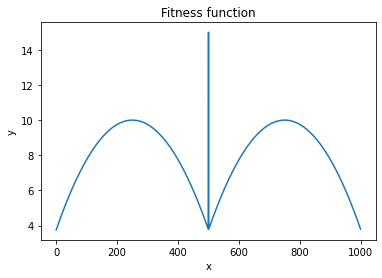

In [4]:
# Problem 1: Sharp Global Peak
def f1(x):
    """
    Fitness must be non-negative, as mlrose evaluates probability simply as fitness/sum(fitness in population)
    """
    if isinstance(x, np.ndarray):  # For compatibility with (one-element) state vector in mlrose
        assert x.shape == (1,)
        x = x[0]
    assert 0 <= x < 1000
    if 0 <= x < 500:
        return 10 - (x - 250) ** 2 / 10000
    elif x == 500:
        return 15
    else:
        return 10 - (x - 750) ** 2 / 10000
    
plot_fitness_function(f1)

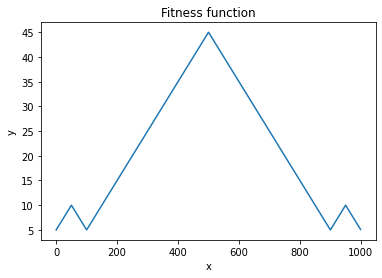

In [5]:
# Problem 2: Wide Basin Global Peak
def f2(x):
    """
    Fitness must be non-negative, as mlrose evaluates probability simply as fitness/sum(fitness in population)
    """
    if isinstance(x, np.ndarray):  # For compatibility with (one-element) state vector in mlrose
        assert x.shape == (1,)
        x = x[0]
    assert 0 <= x < 1000
    if 0 <= x < 100:
        return 10 - abs(x - 50) / 10
    elif x < 900:
        return 45 - abs(x - 500) / 10
    else:
        return 10 - abs(x - 950) / 10
    
plot_fitness_function(f2)

In [6]:
# Problem 3: 0-1 Knapsack Problem
# Reference: https://mlrose.readthedocs.io/en/stable/source/fitness.html#mlrose.fitness.Knapsack
# Best solution from Dynamic Programming: max total value = 7733
values = [
    360, 83, 59, 130, 431, 67, 230, 52, 93, 125, 670, 892, 600, 38, 48, 147,
    78, 256, 63, 17, 120, 164, 432, 35, 92, 110, 22, 42, 50, 323, 514, 28,
    87, 73, 78, 15, 26, 78, 210, 36, 85, 189, 274, 43, 33, 10, 19, 389, 276,
    312
]
weights = [
    7, 1, 30, 22, 80, 94, 11, 81, 70, 64, 59, 18, 1, 36, 3, 8, 15, 42, 9, 1,
    42, 47, 52, 32, 26, 48, 55, 6, 29, 84, 2, 4, 18, 56, 7, 29, 93, 44, 71,
    3, 86, 66, 31, 65, 1, 79, 20, 65, 52, 13
]
max_weight_pct = 0.5
f3 = mlrose.Knapsack(weights, values, max_weight_pct)

## Apply each algorithm on each problem

In [7]:
def plot_fitness_curve(fitness_curves):
    for i, fitness_curve in enumerate(fitness_curves):
        iters = list(range(1, len(fitness_curve) + 1))
        plt.plot(iters, fitness_curve, label='random seed = {}'.format(i))
    plt.legend(loc='lower right')
    plt.title('Fitness curve')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.show()

In [8]:
all_parameters = {
    # Parameters for Problem 1
    'p1': {
        'random_hill_climb': {
            'restarts': 5,
        },
        'simulated_annealing': {
            'schedule': mlrose.ExpDecay(init_temp=1.0, exp_const=0.005, min_temp=0.001),
        },
        'genetic_alg': {
            'pop_size': 200,
            'mutation_prob': 0.4,  # Should be reasonably high to reach the sharp peak fast
        },
        'mimic': {
            'pop_size': 200,
            'keep_pct': 0.2,
        },
    },
    # Parameters for Problem 2
    'p2': {
        'random_hill_climb': {
            'restarts': 5,
        },
        'simulated_annealing': {
            'schedule': mlrose.ExpDecay(init_temp=1.0, exp_const=0.001, min_temp=0.001),
        },
        'genetic_alg': {
            'pop_size': 200,
            'mutation_prob': 0.1,
        },
        'mimic': {
            'pop_size': 200,
            'keep_pct': 0.2,
        },
    },
    # Parameters for Problem 3
    'p3': {
        'random_hill_climb': {
            'restarts': 5,
        },
        'simulated_annealing': {
            'schedule': mlrose.ExpDecay(init_temp=1.0, exp_const=0.005, min_temp=0.001),
        },
        'genetic_alg': {
            'pop_size': 200,
            'mutation_prob': 0.1,
        },
        'mimic': {
            'pop_size': 200,
            'keep_pct': 0.2,
        },
    },
}

In [9]:
global_optimums = {
    'p1': 15,
    'p2': 45,
    'p3': 7733,
}

In [10]:
def get_time_and_iterations_to_reach_global_optimum(total_time, fitness_curve, global_optimum):
    """
    Return time and iterations to reach global optimum
    In addition, return a boolean var indicating whether the global optimum was reached or not
    """
    for i, fitness in enumerate(fitness_curve):
        if fitness == global_optimum:
            return (i + 1) / len(fitness_curve) * total_time, i + 1, True
    return -1, -1, False

In [11]:
def randomized_optimization(fitness_func, algorithm, parameters, random_state):
    if isinstance(fitness_func, mlrose.fitness.Knapsack):
        problem = mlrose.DiscreteOpt(
            length=len(fitness_func.weights),
            fitness_fn=fitness_func,
            maximize=True,
            max_val=2,  # Limit to 0-1 Knapsack Problem
        )
    else:
        fitness = mlrose.CustomFitness(fitness_func)
        problem = mlrose.DiscreteOpt(length=1, fitness_fn=fitness, maximize=True, max_val=1000)
    start_time = time.time()
    if algorithm == 'random_hill_climb':
        best_state, best_fitness, fitness_curve = mlrose.random_hill_climb(
            problem,
            max_attempts=100,
            max_iters=1000,
            # init_state=np.zeros(problem.length),
            random_state=random_state,
            curve=True,
            **parameters,
        )
    elif algorithm == 'simulated_annealing':
        best_state, best_fitness, fitness_curve = mlrose.simulated_annealing(
            problem,
            max_attempts=100,
            max_iters=1000,
            # init_state=np.zeros(problem.length),
            random_state=random_state,
            curve=True,
            **parameters,
        )
    elif algorithm == 'genetic_alg':
        best_state, best_fitness, fitness_curve = mlrose.genetic_alg(
            problem,
            max_attempts=100,
            max_iters=1000,
            random_state=random_state,
            curve=True,
            **parameters,
        )
    elif algorithm == 'mimic':
        best_state, best_fitness, fitness_curve = mlrose.mimic(
            problem,
            max_attempts=10,
            max_iters=1000,
            random_state=random_state,
            curve=True,
            **parameters,
        )
    else:
        raise ValueError('Algorithm {} is not supported!'.format(algoritm))
    end_time = time.time()
    total_time = end_time - start_time
    return best_state, best_fitness, fitness_curve, total_time

-------------------------------------------------------------
Result for algorithm random_hill_climb applied on problem 1
-------------------------------------------------------------
Best state out of all tries = [750]
Best fitnesses for all tries = [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
Best fitness out of all tries = 10.0
Total time (averaged on all tries with different random seeds) = 0.015353798866271973
Time (averaged on all tries with different random seeds) to reach global optimum = -1
Iterations (averaged on all tries with different random seeds) to reach global optimum = -1
Global optimum reached 0 out of 10 times


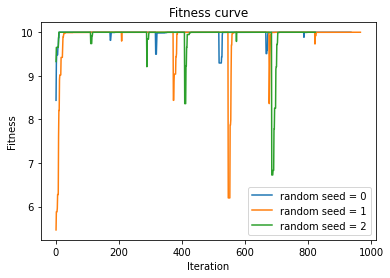

-------------------------------------------------------------
Result for algorithm simulated_annealing applied on problem 1
-------------------------------------------------------------
Best state out of all tries = [247]
Best fitnesses for all tries = [9.9991, 9.9991, 9.9964, 9.9964, 9.9991, 9.99, 9.9879, 9.9856, 9.9975, 9.9856]
Best fitness out of all tries = 9.9991
Total time (averaged on all tries with different random seeds) = 0.02814774513244629
Time (averaged on all tries with different random seeds) to reach global optimum = -1
Iterations (averaged on all tries with different random seeds) to reach global optimum = -1
Global optimum reached 0 out of 10 times


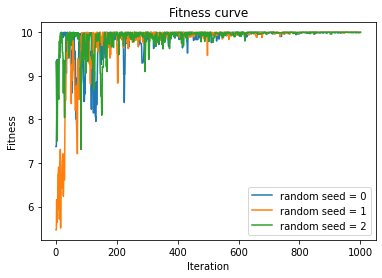

-------------------------------------------------------------
Result for algorithm genetic_alg applied on problem 1
-------------------------------------------------------------
Best state out of all tries = [500]
Best fitnesses for all tries = [15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]
Best fitness out of all tries = 15.0
Total time (averaged on all tries with different random seeds) = 2.6562914848327637
Time (averaged on all tries with different random seeds) to reach global optimum = 0.29042768737702807
Iterations (averaged on all tries with different random seeds) to reach global optimum = 12.3
Global optimum reached 10 out of 10 times


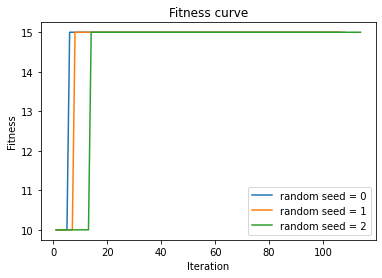

-------------------------------------------------------------
Result for algorithm mimic applied on problem 1
-------------------------------------------------------------
Best state out of all tries = [500]
Best fitnesses for all tries = [9.9996, 9.9999, 10.0, 15.0, 10.0, 9.9999, 10.0, 10.0, 9.9996, 15.0]
Best fitness out of all tries = 15.0
Total time (averaged on all tries with different random seeds) = 0.051299548149108885
Time (averaged on all tries with different random seeds) to reach global optimum = 0.0040728504007512874
Iterations (averaged on all tries with different random seeds) to reach global optimum = 1.0
Global optimum reached 2 out of 10 times


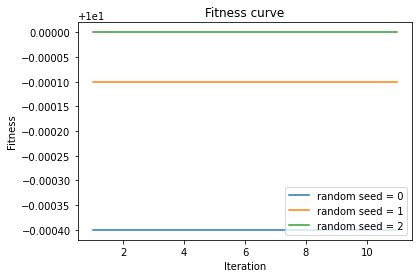

-------------------------------------------------------------
Result for algorithm random_hill_climb applied on problem 2
-------------------------------------------------------------
Best state out of all tries = [500]
Best fitnesses for all tries = [45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0]
Best fitness out of all tries = 45.0
Total time (averaged on all tries with different random seeds) = 0.017108774185180663
Time (averaged on all tries with different random seeds) to reach global optimum = 0.001915800970358296
Iterations (averaged on all tries with different random seeds) to reach global optimum = 110.8
Global optimum reached 10 out of 10 times


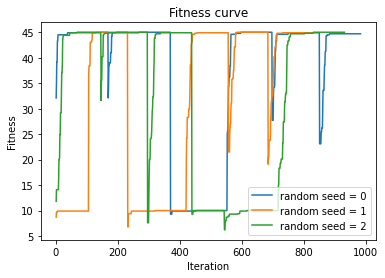

-------------------------------------------------------------
Result for algorithm simulated_annealing applied on problem 2
-------------------------------------------------------------
Best state out of all tries = [500]
Best fitnesses for all tries = [44.9, 44.7, 44.8, 44.6, 45.0, 45.0, 44.7, 44.9, 44.7, 44.7]
Best fitness out of all tries = 45.0
Total time (averaged on all tries with different random seeds) = 0.026442480087280274
Time (averaged on all tries with different random seeds) to reach global optimum = 0.005392259621620178
Iterations (averaged on all tries with different random seeds) to reach global optimum = 213.9
Global optimum reached 10 out of 10 times


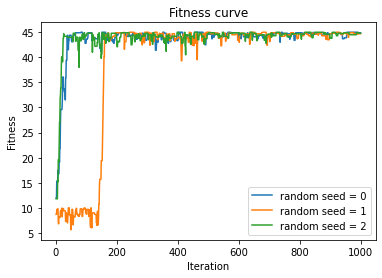

-------------------------------------------------------------
Result for algorithm genetic_alg applied on problem 2
-------------------------------------------------------------
Best state out of all tries = [500]
Best fitnesses for all tries = [45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0]
Best fitness out of all tries = 45.0
Total time (averaged on all tries with different random seeds) = 2.4953957319259645
Time (averaged on all tries with different random seeds) to reach global optimum = 0.9050901927911337
Iterations (averaged on all tries with different random seeds) to reach global optimum = 56.6
Global optimum reached 10 out of 10 times


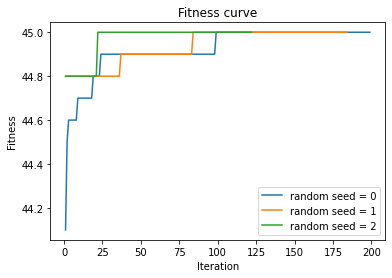

-------------------------------------------------------------
Result for algorithm mimic applied on problem 2
-------------------------------------------------------------
Best state out of all tries = [500]
Best fitnesses for all tries = [44.9, 44.7, 44.8, 45.0, 44.9, 44.3, 44.5, 44.8, 44.4, 45.0]
Best fitness out of all tries = 45.0
Total time (averaged on all tries with different random seeds) = 0.05938279628753662
Time (averaged on all tries with different random seeds) to reach global optimum = 0.003930232741615989
Iterations (averaged on all tries with different random seeds) to reach global optimum = 1.0
Global optimum reached 2 out of 10 times


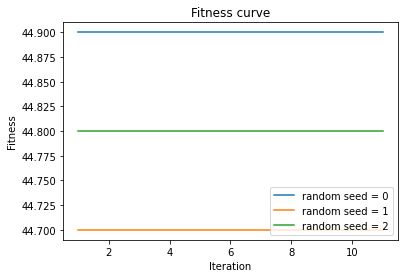

-------------------------------------------------------------
Result for algorithm random_hill_climb applied on problem 3
-------------------------------------------------------------
Best state out of all tries = [1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0
 1 0 1 0 1 0 1 1 0 1 1 0 1]
Best fitnesses for all tries = [5513.0, 5415.0, 4785.0, 5619.0, 5741.0, 5616.0, 6086.0, 5160.0, 4632.0, 5750.0]
Best fitness out of all tries = 6086.0
Total time (averaged on all tries with different random seeds) = 0.04822361469268799
Time (averaged on all tries with different random seeds) to reach global optimum = -1
Iterations (averaged on all tries with different random seeds) to reach global optimum = -1
Global optimum reached 0 out of 10 times


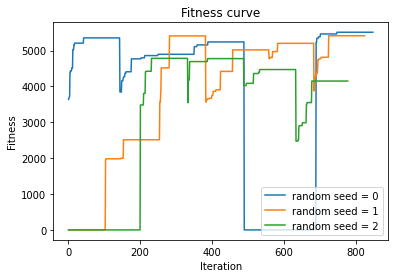

-------------------------------------------------------------
Result for algorithm simulated_annealing applied on problem 3
-------------------------------------------------------------
Best state out of all tries = [0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 0 1 0 0 0 0
 1 1 1 0 0 1 0 1 1 0 1 1 1]
Best fitnesses for all tries = [4873.0, 5462.0, 3015.0, 5570.0, 5385.0, 4301.0, 6461.0, 4866.0, 4881.0, 3905.0]
Best fitness out of all tries = 6461.0
Total time (averaged on all tries with different random seeds) = 0.010184955596923829
Time (averaged on all tries with different random seeds) to reach global optimum = -1
Iterations (averaged on all tries with different random seeds) to reach global optimum = -1
Global optimum reached 0 out of 10 times


/usr/local/lib/python3.8/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)


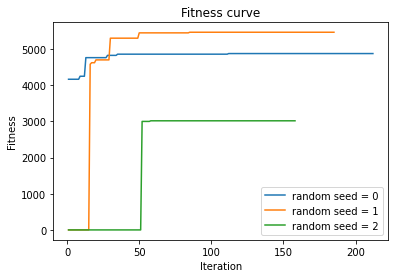

-------------------------------------------------------------
Result for algorithm genetic_alg applied on problem 3
-------------------------------------------------------------
Best state out of all tries = [1 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 0 0
 1 1 1 1 0 1 0 1 0 1 1 1 1]
Best fitnesses for all tries = [6787.0, 6912.0, 7126.0, 6968.0, 7053.0, 6949.0, 6811.0, 6973.0, 6894.0, 7032.0]
Best fitness out of all tries = 7126.0
Total time (averaged on all tries with different random seeds) = 4.907116651535034
Time (averaged on all tries with different random seeds) to reach global optimum = -1
Iterations (averaged on all tries with different random seeds) to reach global optimum = -1
Global optimum reached 0 out of 10 times


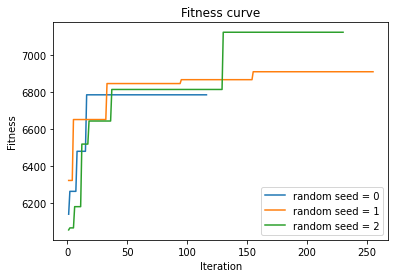

-------------------------------------------------------------
Result for algorithm mimic applied on problem 3
-------------------------------------------------------------
Best state out of all tries = [1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0
 0 1 1 0 1 1 0 1 0 0 1 1 1]
Best fitnesses for all tries = [7596.0, 7597.0, 7713.0, 7483.0, 7612.0, 7685.0, 7729.0, 7731.0, 7616.0, 7679.0]
Best fitness out of all tries = 7731.0
Total time (averaged on all tries with different random seeds) = 21.88003158569336
Time (averaged on all tries with different random seeds) to reach global optimum = -1
Iterations (averaged on all tries with different random seeds) to reach global optimum = -1
Global optimum reached 0 out of 10 times


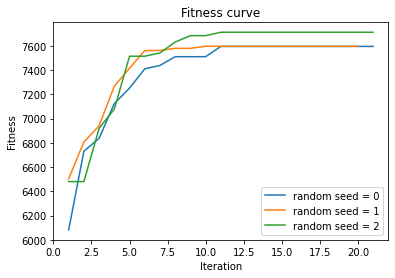

In [12]:
fitness_funcs = [f1, f2, f3]
algorithms = ['random_hill_climb', 'simulated_annealing', 'genetic_alg', 'mimic']
for i, fitness_func in enumerate(fitness_funcs):
    for algorithm in algorithms:
        print('-------------------------------------------------------------')
        print('Result for algorithm {0} applied on problem {1}'.format(algorithm, i + 1))
        print('-------------------------------------------------------------')
        best_state_all_tries = None
        best_fitness_all_tries = -sys.maxsize
        best_fitnesses = []
        fitness_curves = []
        total_times = []
        effective_times = []
        iterations = []
        bools_global_optimum_reached = []
        for random_state in range(10):
            best_state, best_fitness, fitness_curve, total_time = randomized_optimization(
                fitness_func,
                algorithm,
                all_parameters['p{}'.format(i + 1)][algorithm],
                random_state,
            )
            best_fitnesses.append(best_fitness)
            fitness_curves.append(fitness_curve)
            total_times.append(total_time)
            effective_time, iteration, global_optimum_reached \
                = get_time_and_iterations_to_reach_global_optimum(
                    total_time, fitness_curve, global_optimums['p{}'.format(i + 1)],
                )
            if global_optimum_reached:
                effective_times.append(effective_time)
                iterations.append(iteration)
            bools_global_optimum_reached.append(global_optimum_reached)
            # print(fitness_curve)
            if best_fitness > best_fitness_all_tries:
                best_state_all_tries = best_state
                best_fitness_all_tries = best_fitness
        print('Best state out of all tries = {}'.format(best_state_all_tries))
        print('Best fitnesses for all tries = {}'.format(best_fitnesses))
        print('Best fitness out of all tries = {}'.format(best_fitness_all_tries))
        print('Total time (averaged on all tries with different random seeds) = {}'
              .format(sum(total_times) / len(total_times)))
        print('Time (averaged on all tries with different random seeds) to reach global optimum = {}'
              .format(sum(effective_times) / len(effective_times) if len(effective_times) > 0 else -1))
        print('Iterations (averaged on all tries with different random seeds) to reach global optimum = {}'
              .format(sum(iterations) / len(iterations)  if len(iterations) > 0 else -1))
        print('Global optimum reached {0} out of {1} times'
              .format(sum(bools_global_optimum_reached), len(bools_global_optimum_reached)))
        plot_fitness_curve(fitness_curves[:3])